In [6]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/dissertation/data1_desensitized.csv'

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv(file_path)


# Drop unnecessary columns
df.drop(columns=["Unnamed: 17", "Unnamed: 18"], errors="ignore", inplace=True)

# Convert time strings to seconds
def convert_time_to_seconds(time_str):
    try:
        if isinstance(time_str, str) and "'" in time_str:
            minutes, seconds = time_str.split("'")
            return int(minutes) * 60 + int(seconds)
        return np.nan
    except:
        return np.nan

df['800-meter run (sec)'] = df['800-meter run'].apply(convert_time_to_seconds)
df['1000-meter run (sec)'] = df['1000-meter run'].apply(convert_time_to_seconds)

# Drop original time columns
df.drop(columns=['800-meter run', '1000-meter run'], inplace=True)

# Save cleaned file
df.to_csv("cleaned_data1.csv", index=False)


In [8]:
df

,sex,height,weight,vital capacity,50-meter run,standing long jump,sit and reach,one-minute sit-up,pull-up,left naked eye vision,right naked eye vision,refractive error of left eye,refractive error of right eye,left eye string mirror,right eye string mirror,800-meter run (sec),1000-meter run (sec)
0,1,170.0,70.0,2736,6.50,245,23.0,NaN,0.0,5.0,5.0,0,0,0,0,NaN,190.0
1,1,174.1,76.9,3819,9.00,217,4.4,NaN,0.0,5.0,5.0,0,0,0,0,NaN,289.0
2,1,170.0,61.0,3309,7.70,215,16.0,NaN,9.0,4.9,4.9,0,0,0,0,NaN,214.0
3,2,163.0,53.0,3341,7.50,190,25.0,10.0,NaN,4.9,5.0,0,0,0,0,200.0,NaN
4,2,157.9,63.2,2765,10.50,160,25.1,35.0,NaN,5.0,5.0,0,0,0,0,243.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166,1,165.0,64.4,4935,7.50,241,6.6,NaN,3.0,5.0,5.0,0,0,0,0,NaN,254.0
6167,1,175.4,63.3,4439,7.00,250,12.6,NaN,0.0,5.0,5.0,0,0,0,0,NaN,200.0
6168,2,168.1,60.2,2938,8.80,188,15.7,33.0,NaN,4.5,4.1,0,0,0,0,211.0,NaN
6169,2,160.0,66.0,3067,8.54,180,15.0,38.0,NaN,4.4,4.5,0,0,0,0,211.0,NaN


#Z score classification for fitness data

In [9]:
import pandas as pd
from scipy.stats import zscore

# Load cleaned data
df = pd.read_csv("cleaned_data1.csv")

# Separate by gender
df_female = df[df['sex'] == 1].copy()
df_male = df[df['sex'] == 2].copy()

# Feature groups
common_features = ['height', 'weight', 'vital capacity', '50-meter run',
                   'standing long jump', 'sit and reach',
                   'left naked eye vision', 'right naked eye vision']

female_only_features = ['800-meter run (sec)', 'one-minute sit-up']
male_only_features = ['1000-meter run (sec)', 'pull-up']

# Apply z-score
df_female_z = df_female[common_features + female_only_features].apply(zscore)
df_male_z = df_male[common_features + male_only_features].apply(zscore)

# Re-attach gender column
df_female_z['sex'] = 1
df_male_z['sex'] = 2

# Combine
df_z_scores = pd.concat([df_female_z, df_male_z], axis=0).sort_index()

# Classify based on z-score
def classify(z):
    if pd.isna(z):
        return "Missing"
    elif z < -2:
        return "Critical"
    elif z < -1:
        return "Low"
    elif z > 2:
        return "Excellent"
    elif z > 1:
        return "High"
    else:
        return "Normal"

df_performance = df_z_scores.drop(columns=['sex']).map(classify)
df_performance['sex'] = df_z_scores['sex']

# Save final output
df_performance.to_csv("performance_categories.csv", index=False)

In [10]:
df_performance

,height,weight,vital capacity,50-meter run,standing long jump,sit and reach,left naked eye vision,right naked eye vision,800-meter run (sec),one-minute sit-up,1000-meter run (sec),pull-up,sex
0,Normal,Normal,Low,Low,High,High,Normal,Normal,Missing,Missing,Missing,Missing,1
1,Normal,Normal,Normal,High,Normal,Low,Normal,Normal,Missing,Missing,Missing,Missing,1
2,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Missing,Missing,Missing,Missing,1
3,Normal,Normal,High,Critical,High,Normal,Normal,Normal,Missing,Missing,Missing,Missing,2
4,Normal,High,Normal,High,Normal,Normal,Normal,Normal,Missing,Missing,Missing,Missing,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166,Low,Normal,High,Normal,Normal,Low,Normal,Normal,Missing,Missing,Missing,Missing,1
6167,Normal,Normal,Normal,Low,High,Normal,Normal,Normal,Missing,Missing,Missing,Missing,1
6168,High,High,Normal,Normal,High,Normal,Normal,Low,Missing,Missing,Missing,Missing,2
6169,Normal,High,Normal,Normal,Normal,Normal,Normal,Normal,Missing,Missing,Missing,Missing,2


#generate fitness recommendations

In [11]:
import pandas as pd

# Load performance categories
df_performance = pd.read_csv("performance_categories.csv")

# Recommendation generator
def generate_recommendation(row, sex):
    advice = []

    if row.get('vital capacity') in ['Critical', 'Low']:
        advice.append("Add more aerobic exercises like jogging or swimming.")
    if row.get('50-meter run') in ['Critical', 'Low']:
        advice.append("Include sprint drills and agility training.")
    if row.get('standing long jump') in ['Critical', 'Low']:
        advice.append("Incorporate plyometric exercises for explosive strength.")
    if row.get('sit and reach') in ['Critical', 'Low']:
        advice.append("Stretch regularly to improve flexibility.")

    if sex == 1:
        if row.get('800-meter run (sec)') in ['Critical', 'Low']:
            advice.append("Practice paced mid-distance running (e.g., 3–5 laps daily).")
        if row.get('one-minute sit-up') in ['Critical', 'Low']:
            advice.append("Add core strengthening workouts like crunches and planks.")
    elif sex == 2:
        if row.get('1000-meter run (sec)') in ['Critical', 'Low']:
            advice.append("Focus on endurance training with increasing distance.")
        if row.get('pull-up') in ['Critical', 'Low']:
            advice.append("Work on upper body strength using assisted pull-ups and rows.")

    if not advice:
        return "Maintain your current routine. Great job!"
    return " ".join(advice)

# Apply to all rows
df_performance['recommendation'] = df_performance.apply(
    lambda row: generate_recommendation(row, row['sex']), axis=1)

# Save recommendations
df_performance[['sex', 'recommendation']].to_csv("fitness_recommendations.csv", index=False)


In [12]:
df_performance[['sex', 'recommendation']]

,sex,recommendation
0,1,Add more aerobic exercises like jogging or swi...
1,1,Stretch regularly to improve flexibility.
2,1,Maintain your current routine. Great job!
3,2,Include sprint drills and agility training.
4,2,Maintain your current routine. Great job!
...,...,...
6166,1,Stretch regularly to improve flexibility.
6167,1,Include sprint drills and agility training.
6168,2,Maintain your current routine. Great job!
6169,2,Maintain your current routine. Great job!


#Classify personas

In [13]:
import pandas as pd

# Load performance classification CSV
df = pd.read_csv("performance_categories.csv")

# Persona classification function
def classify_persona(row):
    persona = []

    # Cardio and respiratory health
    if row.get("vital capacity") in ["Critical", "Low"]:
        persona.append("Low lung capacity")

    # Upper body strength (male-specific)
    if row.get("pull-up", "Normal") in ["Critical", "Low"]:
        persona.append("Weak upper body")

    # Core strength (female-specific)
    if row.get("one-minute sit-up", "Normal") in ["Critical", "Low"]:
        persona.append("Weak core strength")

    # Flexibility
    if row.get("sit and reach") in ["Critical", "Low"]:
        persona.append("Poor flexibility")

    # Sprint performance
    if row.get("50-meter run") in ["Critical", "Low"]:
        persona.append("Low speed")

    # Endurance (based on gender-specific run)
    if row.get("800-meter run (sec)", "Normal") in ["Critical", "Low"]:
        persona.append("Low endurance")
    if row.get("1000-meter run (sec)", "Normal") in ["Critical", "Low"]:
        persona.append("Low endurance")

    # Fallback if all metrics are Normal or better
    if not persona:
        return "Balanced"

    return ", ".join(persona)

# Apply persona classification
df["persona"] = df.apply(classify_persona, axis=1)

# Save to CSV
df.to_csv("personas_with_classification.csv", index=False)

# Optional: Preview result
print(df[["sex", "persona"]].head(10))


   sex                       persona
0    1  Low lung capacity, Low speed
1    1              Poor flexibility
2    1                      Balanced
3    2                     Low speed
4    2                      Balanced
5    1                      Balanced
6    1                      Balanced
7    2              Poor flexibility
8    2                      Balanced
9    2             Low lung capacity


In [14]:

unique_personas = df['persona'].unique()

# Print unique personas, one per line
for persona in unique_personas:
  print(persona)

Low lung capacity, Low speed
Poor flexibility
Balanced
Low speed
Low lung capacity
Poor flexibility, Low speed
Low lung capacity, Poor flexibility
Low lung capacity, Poor flexibility, Low speed


In [15]:
# prompt: get the total number of records for each persona

# Group by 'persona' and count the number of records
persona_counts = df['persona'].value_counts().reset_index()
persona_counts.columns = ['Persona', 'Total Records']

# Print the result
print("\nTotal number of records for each persona:")
persona_counts


Total number of records for each persona:


,Persona,Total Records
0,Balanced,3844
1,Low lung capacity,724
2,Poor flexibility,701
3,Low speed,601
4,"Low lung capacity, Poor flexibility",178
5,"Poor flexibility, Low speed",82
6,"Low lung capacity, Low speed",34
7,"Low lung capacity, Poor flexibility, Low speed",7


In [16]:
# Persona distribution (your observed counts)
persona_counts = {
    "Balanced": 3844,
    "Low lung capacity": 724,
    "Poor flexibility": 701,
    "Low speed": 601,
    "Low lung capacity, Poor flexibility": 178,
    "Poor flexibility, Low speed": 82,
    "Low lung capacity, Low speed": 34,
    "Low lung capacity, Poor flexibility, Low speed": 7
}

# Total records from dataset
total_records = sum(persona_counts.values())

# Calculate the number of samples to pick from each persona
sampled_per_persona = {
    persona: round((count / total_records) * 100)
    for persona, count in persona_counts.items()
}

# Adjust for rounding errors to ensure sum = 100
adjustment = 100 - sum(sampled_per_persona.values())
if adjustment != 0:
    # Adjust the largest group to make the total 100
    largest_persona = max(sampled_per_persona, key=sampled_per_persona.get)
    sampled_per_persona[largest_persona] += adjustment

# Perform the stratified sampling
sampled_users = pd.DataFrame()
for persona, n in sampled_per_persona.items():
    persona_group = df[df["persona"] == persona]
    if len(persona_group) >= n:
        sampled = persona_group.sample(n=n, random_state=42)
    else:
        sampled = persona_group  # use all if not enough (you may oversample if desired)
    sampled_users = pd.concat([sampled_users, sampled], axis=0)

# Reset index
sampled_users.reset_index(drop=True, inplace=True)

# Save to CSV
sampled_users.to_csv("stratified_100_users.csv", index=False)

# Show summary
print("Sampled user counts by persona:")
print(sampled_users["persona"].value_counts())

Sampled user counts by persona:
persona
Balanced                               62
Low lung capacity                      12
Poor flexibility                       11
Low speed                              10
Low lung capacity, Poor flexibility     3
Poor flexibility, Low speed             1
Low lung capacity, Low speed            1
Name: count, dtype: int64


#Assign Workout Plan based on Persona

In [17]:
import pandas as pd

# Load stratified user data
df = pd.read_csv("stratified_100_users.csv")

# Define a workout plan per persona
workout_plans = {
    "Balanced": [
        "Alternate cardio and strength days.",
        "3x/week full-body strength.",
        "2x/week cardio (30 min run/walk).",
        "1x/week flexibility/mobility."
    ],
    "Low lung capacity": [
        "Daily deep breathing + light cardio (20 min walk).",
        "Progressive interval jogging (2x/week).",
        "Stretch after cardio to aid breathing.",
        "Yoga-based diaphragmatic breathing (1x/week)."
    ],
    "Poor flexibility": [
        "Daily dynamic stretching (10 min).",
        "2x/week full yoga sessions.",
        "Hold static stretches post-workout (30 sec each).",
        "Weekly flexibility assessment."
    ],
    "Low speed": [
        "Sprint drills (short bursts x 6, 3x/week).",
        "Agility ladder and cone drills.",
        "Lower-body strength: squats, jumps (2x/week).",
        "Rest and foam roll post sprints."
    ],
    "Low lung capacity, Poor flexibility": [
        "20-min brisk walking daily.",
        "Breathing-focused yoga (2x/week).",
        "Stretch hamstrings, hip flexors daily.",
        "Include rest day after intense activity."
    ],
    "Poor flexibility, Low speed": [
        "Stretching routine + agility work alternate days.",
        "Foam rolling lower body.",
        "Plyometric drills with proper cooldown.",
        "Weekly improvement test (e.g., sit-and-reach)."
    ],
    "Low lung capacity, Low speed": [
        "Start with light cardio (walking) daily.",
        "Short sprints + recovery walk (2x/week).",
        "Breathwork + stretching after cardio.",
        "Add aerobic games (e.g., cycling, swimming)."
    ],
    "Low lung capacity, Poor flexibility, Low speed": [
        "Low-impact cardio (cycling, swimming).",
        "Progressive breath training.",
        "Guided yoga/stretching 3x/week.",
        "Supervised sprint technique drills."
    ]
}

# Assign workout plans
def assign_plan(persona):
    return workout_plans.get(persona, ["Generic full-body routine", "Light cardio", "Stretch", "Rest day"])

# Add workout plan column
df["weekly_workout_plan"] = df["persona"].apply(assign_plan)

# Save to new CSV
df.to_csv("users_with_workout_plans.csv", index=False)

# Preview
for i, row in df.head(5).iterrows():
    print(f"\nPersona: {row['persona']}")
    for day, plan in enumerate(row["weekly_workout_plan"], 1):
        print(f"Day {day}: {plan}")



Persona: Balanced
Day 1: Alternate cardio and strength days.
Day 2: 3x/week full-body strength.
Day 3: 2x/week cardio (30 min run/walk).
Day 4: 1x/week flexibility/mobility.

Persona: Balanced
Day 1: Alternate cardio and strength days.
Day 2: 3x/week full-body strength.
Day 3: 2x/week cardio (30 min run/walk).
Day 4: 1x/week flexibility/mobility.

Persona: Balanced
Day 1: Alternate cardio and strength days.
Day 2: 3x/week full-body strength.
Day 3: 2x/week cardio (30 min run/walk).
Day 4: 1x/week flexibility/mobility.

Persona: Balanced
Day 1: Alternate cardio and strength days.
Day 2: 3x/week full-body strength.
Day 3: 2x/week cardio (30 min run/walk).
Day 4: 1x/week flexibility/mobility.

Persona: Balanced
Day 1: Alternate cardio and strength days.
Day 2: 3x/week full-body strength.
Day 3: 2x/week cardio (30 min run/walk).
Day 4: 1x/week flexibility/mobility.


In [18]:
# prompt: print record where persona is poor flexibility

# Filter the DataFrame to find records where the 'persona' is 'Poor flexibility'
poor_flexibility_records = df[df['persona'] == 'Poor flexibility']

# Print the filtered records
print("\nRecords with 'Poor flexibility' persona:")
poor_flexibility_records


Records with 'Poor flexibility' persona:


,height,weight,vital capacity,50-meter run,standing long jump,sit and reach,left naked eye vision,right naked eye vision,800-meter run (sec),one-minute sit-up,1000-meter run (sec),pull-up,sex,persona,weekly_workout_plan
74,Normal,Normal,Normal,Normal,Normal,Low,Normal,Normal,Missing,Missing,Missing,Missing,1,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
75,Normal,Normal,Normal,High,Low,Low,Normal,Normal,Missing,Missing,Missing,Missing,1,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
76,Normal,Normal,Normal,Normal,Normal,Low,Normal,Normal,Missing,Missing,Missing,Missing,2,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
77,Low,Normal,High,Normal,Normal,Low,Critical,Critical,Missing,Missing,Missing,Missing,2,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
78,High,Normal,Normal,Normal,Normal,Low,Normal,Normal,Missing,Missing,Missing,Missing,2,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
79,Normal,Low,Normal,Normal,Normal,Critical,Normal,Normal,Missing,Missing,Missing,Missing,1,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
80,Low,Normal,Normal,Normal,Normal,Low,Critical,Normal,Missing,Missing,Missing,Missing,2,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
81,Normal,Normal,High,Normal,Critical,Low,Low,Low,Missing,Missing,Missing,Missing,1,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
82,Normal,Normal,Normal,Normal,Excellent,Low,High,Normal,Missing,Missing,Missing,Missing,1,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."
83,Normal,Normal,Normal,Normal,High,Low,Normal,Normal,Missing,Missing,Missing,Missing,1,Poor flexibility,"[Daily dynamic stretching (10 min)., 2x/week f..."


##Static SNPERS Plan with Persona2-based Adherence

In [19]:
import pandas as pd
import numpy as np
import random
import ast

# === Step 1: Load users with persona1 ===
df = pd.read_csv("users_with_workout_plans.csv")
df["weekly_workout_plan"] = df["weekly_workout_plan"].apply(ast.literal_eval)

# ✅ Ensure user_id exists
if "student id" in df.columns:
    df["user_id"] = df["student id"]
else:
    df["user_id"] = df.index  # fallback if no student id

# === Step 2: Define static plans per Persona 1 ===
static_plans = {
    "Balanced": ["Cardio", "Strength", "Flexibility", "Rest or Free Day"],
    "Low lung capacity": ["Breathwork or Yoga", "Flexibility", "Cardio", "Rest or Free Day"],
    "Low speed": ["Strength", "Cardio", "Rest or Free Day", "Breathwork or Yoga"],
    "Poor flexibility": ["Flexibility", "Strength", "Cardio", "Rest or Free Day"],
    "Weak upper body": ["Strength", "Strength", "Cardio", "Rest or Free Day"],
    "Weak core strength": ["Strength", "Flexibility", "Cardio", "Rest or Free Day"],
    "Low endurance": ["Cardio", "Cardio", "Flexibility", "Rest or Free Day"]
}

# === Step 3: Define Persona2 preference model ===
persona2_preferences = {
    "prefers_cardio":   [0.9, 0.5, 0.4, 0.4, 0.3],
    "prefers_yoga":     [0.3, 0.4, 0.4, 0.9, 0.4],
    "prefers_strength": [0.4, 0.9, 0.3, 0.3, 0.4],
    "balanced":         [0.6, 0.6, 0.6, 0.6, 0.6]
}

# Map workouts to action IDs
workout_to_action = {
    "Cardio": 0,
    "Strength": 1,
    "Flexibility": 2,
    "Breathwork or Yoga": 3,
    "Other": 4,
    "Rest or Free Day": 5
}

# === Step 4: Assign Persona2 to each user ===
user_ids = df["user_id"].unique()
persona2_assignment = {
    user_id: random.choice(list(persona2_preferences.keys()))
    for user_id in user_ids
}

# === Step 5: Simulate adherence based on Persona2 preferences ===
def simulate_followed(user_id, action):
    persona2 = persona2_assignment[user_id]
    prob = persona2_preferences[persona2][action] if action < 5 else 1.0
    return 1 if random.random() < prob else 0

# === Step 6: Simulate 4-week logs for SNPERS (static plan) ===
NUM_DAYS = 28
WEEK_PLAN_DAYS = 4

def simulate_sn_feedback(user_id, persona1, persona2, static_plan):
    logs = []
    for day in range(1, NUM_DAYS + 1):
        week_day = (day - 1) % 7
        plan_day = week_day if week_day < WEEK_PLAN_DAYS else None
        workout = static_plan[plan_day] if plan_day is not None else "Rest or Free Day"
        action = workout_to_action[workout]

        followed = simulate_followed(user_id, action)
        emotion = 3 if action == 5 else (
            np.random.choice([3, 4, 5], p=[0.3, 0.5, 0.2]) if followed else np.random.choice([1, 2], p=[0.6, 0.4])
        )

        logs.append({
            "user_id": user_id,
            "day": day,
            "persona1": persona1,
            "persona2": persona2,
            "workout": workout,
            "action": action,
            "followed": followed,
            "emotion_score": emotion
        })
    return logs

# === Step 7: Generate all user logs ===
all_logs = []
for _, row in df.iterrows():
    user_id = row["user_id"]
    persona1 = row["persona"]
    static_plan = static_plans.get(persona1, static_plans["Balanced"])
    persona2 = persona2_assignment[user_id]
    logs = simulate_sn_feedback(user_id, persona1, persona2, static_plan)
    all_logs.extend(logs)

# === Step 8: Save to CSV ===
sn_df = pd.DataFrame(all_logs)
sn_df.to_csv("user_feedback_sn_baseline.csv", index=False)
print("✅ Static SNPERS simulation complete. File saved as: user_feedback_sn_baseline.csv")


✅ Static SNPERS simulation complete. File saved as: user_feedback_sn_baseline.csv


#Simulate 4 week user feedback

In [20]:
import pandas as pd
import numpy as np
import random
import ast

# === Step 1: Load user workout plans ===
df = pd.read_csv("users_with_workout_plans.csv")
df["weekly_workout_plan"] = df["weekly_workout_plan"].apply(ast.literal_eval)

# Handle user ID column robustly
if "student id" in df.columns:
    user_ids = df["student id"].unique()
    user_id_column = "student id"
else:
    df["user_id"] = df.index
    user_ids = df["user_id"].unique()
    user_id_column = "user_id"

# === Step 2: Define Persona 2 preferences ===
persona2_preferences = {
    "prefers_cardio":   [0.9, 0.5, 0.4, 0.4, 0.3],
    "prefers_yoga":     [0.3, 0.4, 0.4, 0.9, 0.4],
    "prefers_strength": [0.4, 0.9, 0.3, 0.3, 0.4],
    "balanced":         [0.6, 0.6, 0.6, 0.6, 0.6]
}

# === Step 3: Assign a Persona 2 to each user ===
persona2_assignment = {
    user_id: random.choice(list(persona2_preferences.keys()))
    for user_id in user_ids
}

# === Step 4: Function to simulate followed based on persona2 ===
def simulate_followed(user_id, action):
    persona = persona2_assignment[user_id]
    prob = persona2_preferences[persona][action]
    return 1 if random.random() < prob else 0

# === Step 5: Map workouts to action IDs ===
REST_DAY = "Rest or Free Day"
workout_to_action = {
    "Cardio": 0,
    "Strength": 1,
    "Flexibility": 2,
    "Breathwork or Yoga": 3,
    "Other": 4,
    REST_DAY: 5  # Use 5 to explicitly encode Rest day
}

# === Step 6: Normalize free-text workouts ===
def categorize_workout(text):
    text = str(text).lower()
    if "cardio" in text:
        return "Cardio"
    elif "strength" in text or "full-body" in text:
        return "Strength"
    elif "flexibility" in text or "mobility" in text:
        return "Flexibility"
    elif "yoga" in text or "breathwork" in text:
        return "Breathwork or Yoga"
    elif text.strip() == REST_DAY.lower():
        return REST_DAY
    else:
        return "Other"

# === Step 7: Simulate 4-week feedback per user ===
NUM_DAYS = 28
WEEK_PLAN_DAYS = 4

def simulate_user_feedback(user_id, persona1, persona2, plan):
    logs = []
    for day in range(1, NUM_DAYS + 1):
        week_day = (day - 1) % 7
        plan_day = week_day if week_day < WEEK_PLAN_DAYS else None
        raw_workout = plan[plan_day] if plan_day is not None else REST_DAY
        workout = categorize_workout(raw_workout)
        action = workout_to_action.get(workout, 4)  # Default to 'Other'

        # Simulate follow and emotion
        if action == 5:  # Rest day
            followed = 1
            emotion = 3
        else:
            followed = simulate_followed(user_id, action)
            emotion = np.random.choice([3, 4, 5], p=[0.3, 0.5, 0.2]) if followed == 1 else np.random.choice([1, 2], p=[0.6, 0.4])

        logs.append({
            "user_id": user_id,
            "day": day,
            "persona1": persona1,
            "persona2": persona2,
            "raw_workout": raw_workout,
            "workout": workout,
            "action": action,
            "followed": followed,
            "emotion_score": emotion
        })
    return logs

# === Step 8: Simulate logs for all users ===
all_logs = []
for _, row in df.iterrows():
    user_id = row[user_id_column]
    persona1 = row["persona"]
    persona2 = persona2_assignment[user_id]
    plan = row["weekly_workout_plan"]
    logs = simulate_user_feedback(user_id, persona1, persona2, plan)
    all_logs.extend(logs)

# === Step 9: Save output ===
feedback_df = pd.DataFrame(all_logs)
feedback_df.to_csv("user_feedback_simulated_4weeks.csv", index=False)
print("✅ Simulation complete. Preview:")
print(feedback_df.head(10))


✅ Simulation complete. Preview:
   user_id  day  persona1        persona2  \
0        0    1  Balanced  prefers_cardio   
1        0    2  Balanced  prefers_cardio   
2        0    3  Balanced  prefers_cardio   
3        0    4  Balanced  prefers_cardio   
4        0    5  Balanced  prefers_cardio   
5        0    6  Balanced  prefers_cardio   
6        0    7  Balanced  prefers_cardio   
7        0    8  Balanced  prefers_cardio   
8        0    9  Balanced  prefers_cardio   
9        0   10  Balanced  prefers_cardio   

                           raw_workout           workout  action  followed  \
0  Alternate cardio and strength days.            Cardio       0         1   
1          3x/week full-body strength.          Strength       1         1   
2    2x/week cardio (30 min run/walk).            Cardio       0         1   
3        1x/week flexibility/mobility.       Flexibility       2         0   
4                     Rest or Free Day  Rest or Free Day       5         1   
5   

##Compute Reward Column

In [21]:
import pandas as pd

# Load the 4-week feedback simulation
df = pd.read_csv("user_feedback_simulated_4weeks.csv")

# Define reward function
def compute_reward(row):
    base = 1.0 if row["followed"] else -1.0
    emotion_adjustment = (row["emotion_score"] - 3) * 0.5
    return base + emotion_adjustment

# Apply reward calculation
df["reward"] = df.apply(compute_reward, axis=1)

# Save result
df.to_csv("user_feedback_with_rewards.csv", index=False)

# Preview
print(df[["user_id", "day", "followed", "emotion_score", "reward"]].head(10))


   user_id  day  followed  emotion_score  reward
0        0    1         1              4     1.5
1        0    2         1              4     1.5
2        0    3         1              4     1.5
3        0    4         0              1    -2.0
4        0    5         1              3     1.0
5        0    6         1              3     1.0
6        0    7         1              3     1.0
7        0    8         1              5     2.0
8        0    9         0              1    -2.0
9        0   10         1              3     1.0


##Compute RTWS EMA reward

In [22]:
df.columns

Index(['user_id', 'day', 'persona1', 'persona2', 'raw_workout', 'workout',
       'action', 'followed', 'emotion_score', 'reward'],
      dtype='object')

In [23]:
import pandas as pd

# Load user feedback data
df = pd.read_csv("user_feedback_simulated_4weeks.csv")

# Step 1: Convert emotion_score (1–5) to RTWS in range [-1, 1]
df["rtws"] = (df["emotion_score"] - 3) / 2  # e.g., 1→-1.0, 3→0.0, 5→+1.0

# Step 2: Initialize new columns
df["ema"] = 0.0
df["lambda_t"] = 0.3  # You can make this dynamic later if needed
df["final_reward"] = 0.0

# Step 3: Set smoothing factor for EMA
alpha = 0.3

# Step 4: Compute EMA and final_reward per user
for user_id, group in df.groupby("user_id"):
    ema_prev = 0
    ema_list = []
    reward_list = []

    for rtws in group["rtws"]:
        ema_now = alpha * rtws + (1 - alpha) * ema_prev
        reward = (1 - 0.3) * rtws + 0.3 * ema_now
        ema_list.append(ema_now)
        reward_list.append(reward)
        ema_prev = ema_now

    # Update DataFrame
    df.loc[df["user_id"] == user_id, "ema"] = ema_list
    df.loc[df["user_id"] == user_id, "final_reward"] = reward_list

# Step 5: Save results
df.to_csv("user_feedback_with_rtws_ema_reward.csv", index=False)

# Optional: Preview a few rows
print(df[["user_id", "day", "followed", "emotion_score", "rtws", "ema", "final_reward"]].head(10))


   user_id  day  followed  emotion_score  rtws       ema  final_reward
0        0    1         1              4   0.5  0.150000      0.395000
1        0    2         1              4   0.5  0.255000      0.426500
2        0    3         1              4   0.5  0.328500      0.448550
3        0    4         0              1  -1.0 -0.070050     -0.721015
4        0    5         1              3   0.0 -0.049035     -0.014710
5        0    6         1              3   0.0 -0.034324     -0.010297
6        0    7         1              3   0.0 -0.024027     -0.007208
7        0    8         1              5   1.0  0.283181      0.784954
8        0    9         0              1  -1.0 -0.101773     -0.730532
9        0   10         1              3   0.0 -0.071241     -0.021372


##Plot the RTWS, EMA and Total Reward

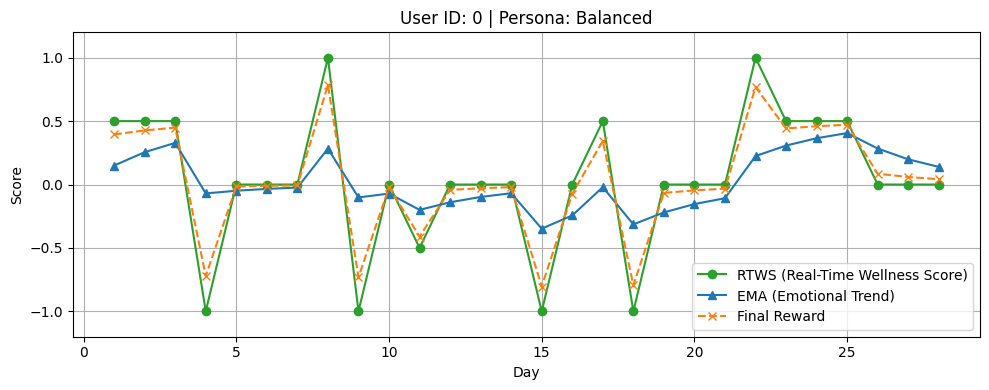

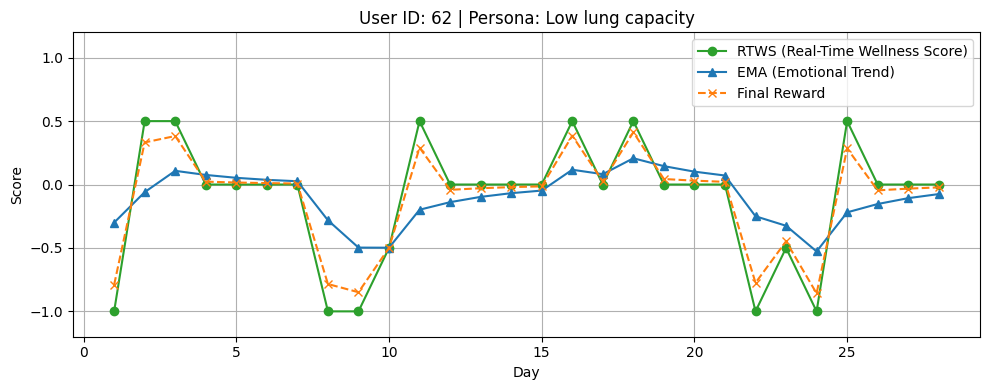

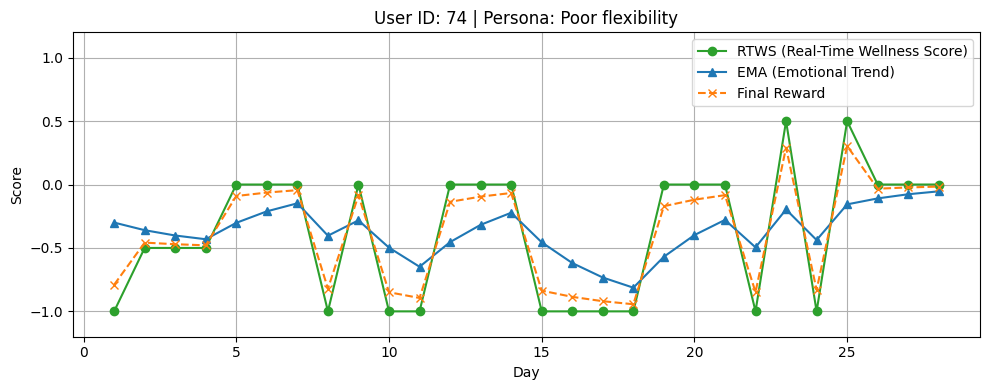

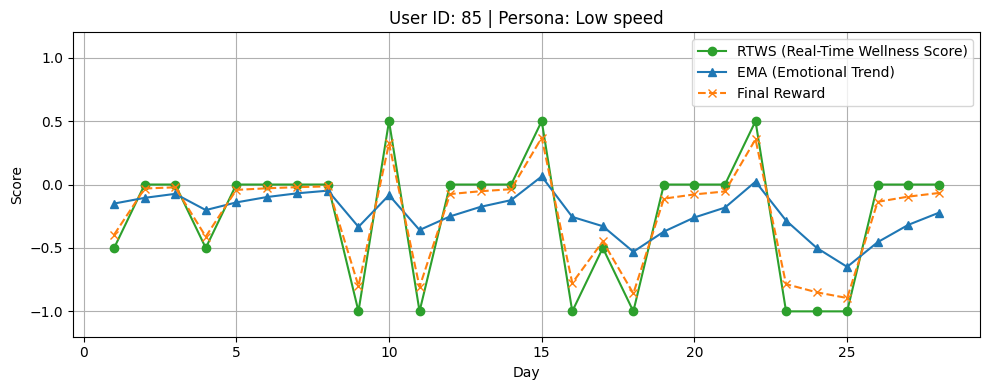

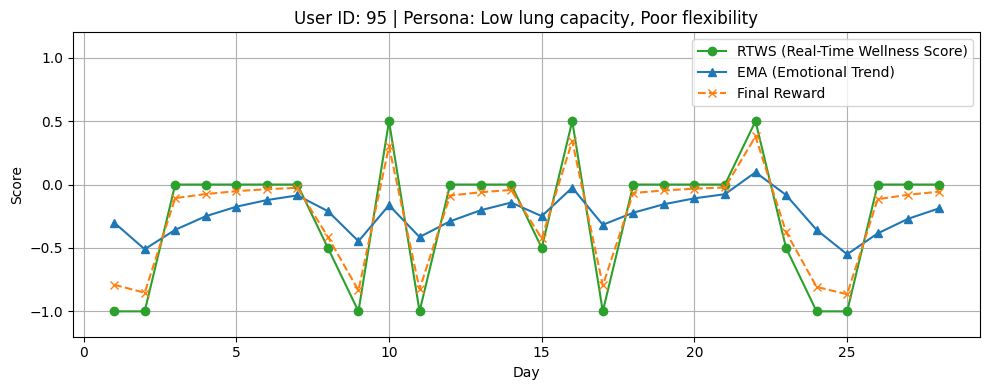

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("user_feedback_with_rtws_ema_reward.csv")

# ✅ Select one user per unique persona (up to 5 personas)
selected_users = []
seen_personas = set()

for user_id, group in df.groupby("user_id"):
    persona = group["persona1"].iloc[0]
    if persona not in seen_personas:
        selected_users.append(user_id)
        seen_personas.add(persona)
    if len(selected_users) >= 5:
        break

# ✅ Plot RTWS, EMA, and Final Reward for each user
for user_id in selected_users:
    user_data = df[df["user_id"] == user_id]
    days = user_data["day"]
    rtws = user_data["rtws"]
    ema = user_data["ema"]
    reward = user_data["final_reward"]
    persona = user_data["persona1"].iloc[0]

    plt.figure(figsize=(10, 4))
    plt.plot(days, rtws, label="RTWS (Real-Time Wellness Score)", color='tab:green', marker='o')
    plt.plot(days, ema, label="EMA (Emotional Trend)", color='tab:blue', marker='^')
    plt.plot(days, reward, label="Final Reward", color='tab:orange', linestyle='--', marker='x')
    plt.title(f"User ID: {user_id} | Persona: {persona}")
    plt.xlabel("Day")
    plt.ylabel("Score")
    plt.ylim(-1.2, 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##generate an RL-ready replay buffer from your user_feedback_with_rtws_ema_reward.csv dataset. This buffer includes:

state

action (workout type encoding)

reward (RTWS + EMA)

next_state

done (episode end flag)

In [25]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("user_feedback_with_rtws_ema_reward.csv")

# --- Define helper functions ---

# Simulate a minimal state vector
def extract_state(row, history):
    avg_ema = np.mean(history[-3:]) if len(history) >= 3 else row["ema"]
    return [
        int(row["followed"]),        # Convert boolean to int (1 or 0)
        row["emotion_score"],        # Emotion (1–5)
        avg_ema                      # Short-term emotional trend
    ]

# Encode action based on workout description
def encode_action(workout):
    workout = str(workout).lower()
    if "cardio" in workout:
        return 0
    elif "strength" in workout:
        return 1
    elif "stretch" in workout or "flexibility" in workout:
        return 2
    elif "yoga" in workout or "breath" in workout:
        return 3
    else:
        return 4  # Unknown or rest day

# --- Build the replay buffer ---

replay_buffer = []

for user_id, group in df.groupby("user_id"):
    group = group.sort_values("day").reset_index(drop=True)
    history = []

    for i in range(len(group) - 1):  # Stop at second-last to get next_state
        current = group.iloc[i]
        next_row = group.iloc[i + 1]

        state = extract_state(current, history)
        action = encode_action(current["workout"])
        reward = current["final_reward"]
        next_state = extract_state(next_row, history + [current["emotion_score"]])
        done = (i + 1 == len(group) - 1)

        replay_buffer.append({
            "user_id": user_id,
            "day": current["day"],
            "state": state,
            "action": action,
            "reward": reward,
            "next_state": next_state,
            "done": done
        })

# --- Save as CSV ---
replay_df = pd.DataFrame(replay_buffer)
replay_df.to_csv("replay_buffer_rl_ready.csv", index=False)

# Preview
print(replay_df.head())


   user_id  day                        state  action    reward  \
0        0    1                 [1, 4, 0.15]       0  0.395000   
1        0    2                [1, 4, 0.255]       1  0.426500   
2        0    3               [1, 4, 0.3285]       0  0.448550   
3        0    4             [0, 1, -0.07005]       2 -0.721015   
4        0    5  [1, 3, -0.0490349999999999]       4 -0.014710   

                    next_state   done  
0                [1, 4, 0.255]  False  
1               [1, 4, 0.3285]  False  
2             [0, 1, -0.07005]  False  
3  [1, 3, -0.0490349999999999]  False  
4  [1, 3, -0.0343244999999999]  False  


##Reward progression of 3 users over 28 days

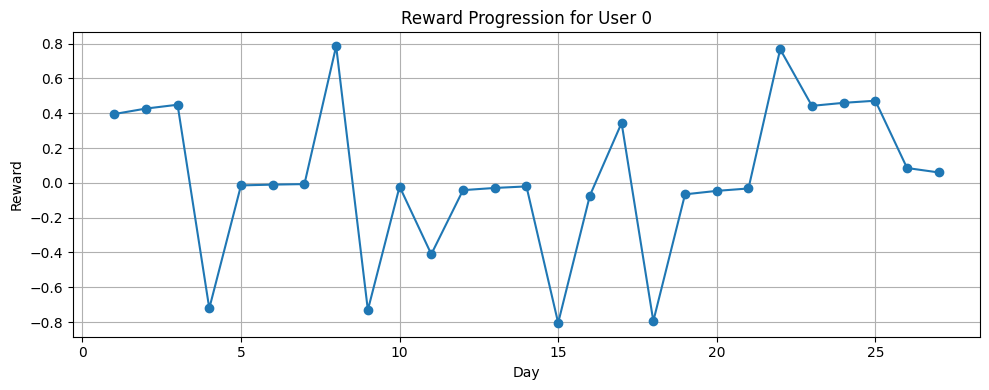

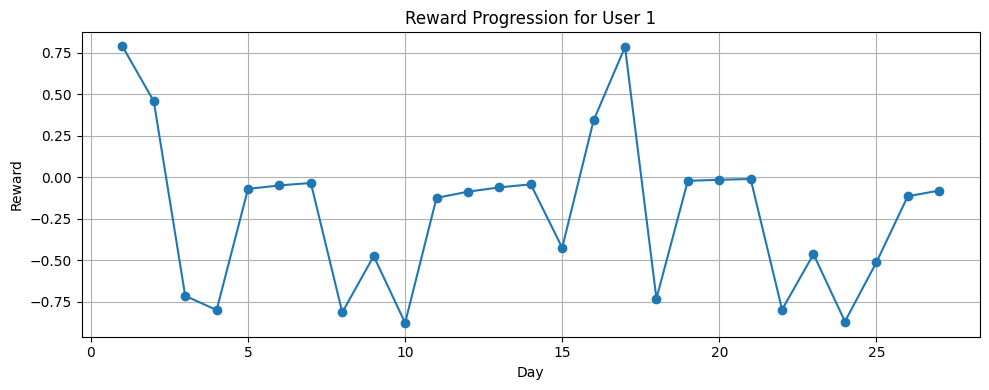

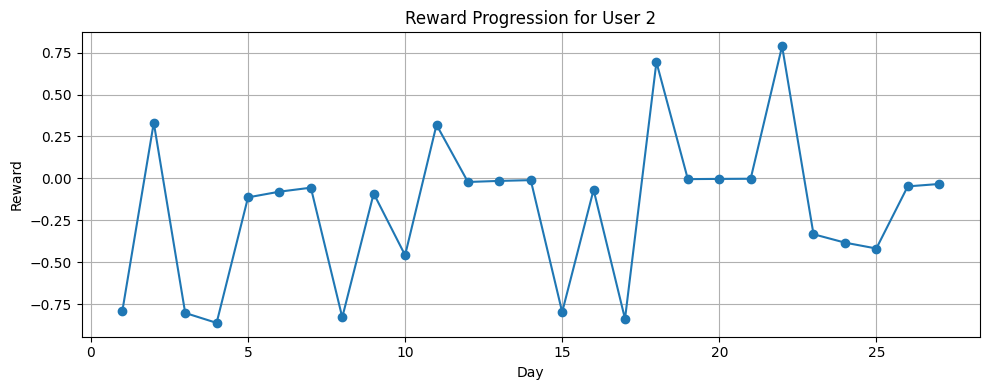

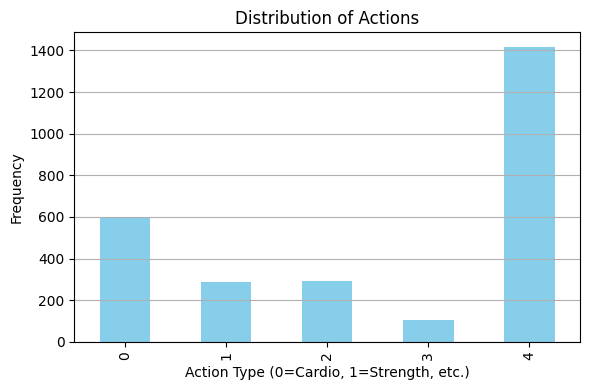

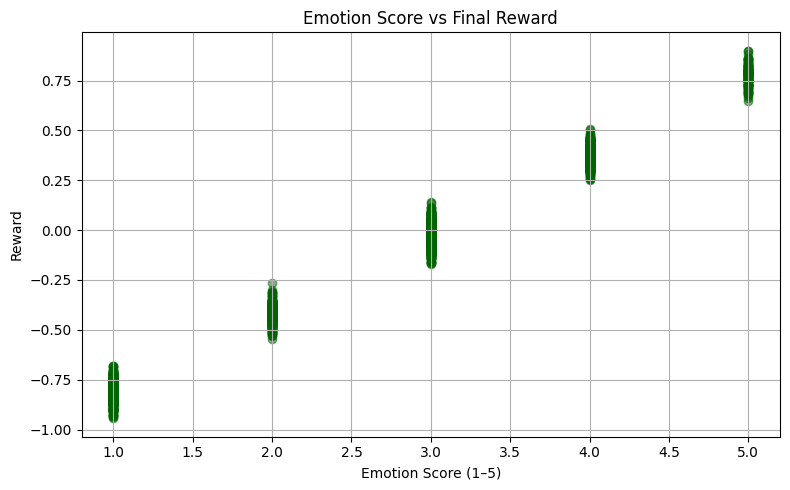

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Import numpy here

# Load the replay buffer
df = pd.read_csv("replay_buffer_rl_ready.csv")

# Safe evaluation of 'state' and 'next_state' containing booleans
# Pass numpy as part of the environment for eval
df["state"] = df["state"].apply(lambda x: eval(x, {"__builtins__": {}, 'np': np}, {}))
df["next_state"] = df["next_state"].apply(lambda x: eval(x, {"__builtins__": {}, 'np': np}, {}))


# Extract components from the state
df["followed_flag"] = df["state"].apply(lambda x: int(x[0]))
df["emotion_score"] = df["state"].apply(lambda x: x[1])
df["avg_ema"] = df["state"].apply(lambda x: x[2])

# 📈 Reward progression for 3 users
for user_id in df["user_id"].unique()[:3]:
    user_df = df[df["user_id"] == user_id]
    plt.figure(figsize=(10, 4))
    plt.plot(user_df["day"], user_df["reward"], marker='o')
    plt.title(f"Reward Progression for User {user_id}")
    plt.xlabel("Day")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📊 Action type distribution
plt.figure(figsize=(6, 4))
df["action"].value_counts().sort_index().plot(kind="bar", color='skyblue')
plt.title("Distribution of Actions")
plt.xlabel("Action Type (0=Cardio, 1=Strength, etc.)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 🎯 Emotion score vs reward
plt.figure(figsize=(8, 5))
plt.scatter(df["emotion_score"], df["reward"], alpha=0.5, c='darkgreen')
plt.title("Emotion Score vs Final Reward")
plt.xlabel("Emotion Score (1–5)")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# ⚙️ Install dependencies (only needed on Colab or Kaggle)
!pip install torch scikit-learn pandas matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00


##Q-Learning with a Neural Network (aka Deep Q-Network, DQN)

Epoch 1/20 - Loss: 2.7995
Epoch 2/20 - Loss: 1.1411
Epoch 3/20 - Loss: 0.5564
Epoch 4/20 - Loss: 0.3838
Epoch 5/20 - Loss: 0.3084
Epoch 6/20 - Loss: 0.2614
Epoch 7/20 - Loss: 0.2317
Epoch 8/20 - Loss: 0.2165
Epoch 9/20 - Loss: 0.2151
Epoch 10/20 - Loss: 0.2103
Epoch 11/20 - Loss: 0.2110
Epoch 12/20 - Loss: 0.2086
Epoch 13/20 - Loss: 0.2112
Epoch 14/20 - Loss: 0.2053
Epoch 15/20 - Loss: 0.2069
Epoch 16/20 - Loss: 0.2057
Epoch 17/20 - Loss: 0.2149
Epoch 18/20 - Loss: 0.2058
Epoch 19/20 - Loss: 0.2050
Epoch 20/20 - Loss: 0.2070


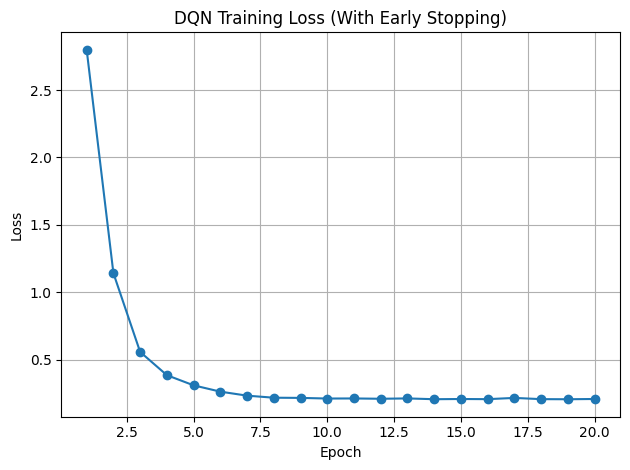

✅ Model saved to: dqn_trained_model.pth


In [28]:
# 📚 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 📂 Load replay buffer
df = pd.read_csv("replay_buffer_rl_ready.csv")

# ✅ Safe eval for state columns
safe_globals = {"__builtins__": {}, "True": True, "False": False, "np": np}
df["state"] = df["state"].apply(lambda x: eval(x, safe_globals, {}))
df["next_state"] = df["next_state"].apply(lambda x: eval(x, safe_globals, {}))

# 🧮 Normalize state vectors
scaler = MinMaxScaler()
states_scaled = scaler.fit_transform(df["state"].tolist())
next_states_scaled = scaler.transform(df["next_state"].tolist())

# ✅ Clip rewards to avoid Q explosions
rewards = np.clip(df["reward"].values, -1, 1)
actions = df["action"].values
dones = df["done"].astype(int).values

# 🎒 Dataset class
class RLDataset(Dataset):
    def __init__(self, states, actions, rewards, next_states, dones):
        self.states = torch.tensor(states, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.int64)
        self.rewards = torch.tensor(rewards, dtype=torch.float32)
        self.next_states = torch.tensor(next_states, dtype=torch.float32)
        self.dones = torch.tensor(dones, dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[idx]

# 🧠 DQN model
class DQN(nn.Module):
    def __init__(self, input_dim=3, output_dim=5):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# ⚙️ Training setup
dataset = RLDataset(states_scaled, actions, rewards, next_states_scaled, dones)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = DQN()
target_model = DQN()
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.SmoothL1Loss()
gamma = 0.99
target_update_freq = 20
max_epochs = 20
loss_threshold = 0.011

# 🏋️ Training loop with early stopping
losses = []
for epoch in range(max_epochs):
    total_loss = 0
    for state, action, reward, next_state, done in loader:
        q_values = model(state)
        next_q_values = target_model(next_state).max(1)[0].detach()
        q_target = reward + (1 - done) * gamma * next_q_values
        q_pred = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

        loss = loss_fn(q_pred, q_target)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

    avg_loss = total_loss
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{max_epochs} - Loss: {avg_loss:.4f}")

    if avg_loss <= loss_threshold:
        print(f"✅ Early stopping: Loss converged to {avg_loss:.4f} at epoch {epoch+1}")
        break

# 📊 Plot training loss
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title("DQN Training Loss (With Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# 💾 Save model
torch.save(model.state_dict(), "dqn_trained_model.pth")
print("✅ Model saved to: dqn_trained_model.pth")


##Evaluate the model on sample states

In [29]:
# 📚 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# 🧠 Same model as in training
class DQN(nn.Module):
    def __init__(self, input_dim=3, output_dim=5):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# 📂 Load and parse replay buffer
df = pd.read_csv("replay_buffer_rl_ready.csv")
safe_globals = {"__builtins__": {}, "True": True, "False": False, "np": np}
df["state"] = df["state"].apply(lambda x: eval(x, safe_globals, {}))

# 🔁 Normalize using same scaling as training
scaler = MinMaxScaler()
scaled_states = scaler.fit_transform(df["state"].tolist())

# 🧠 Load trained model
model = DQN()
model.load_state_dict(torch.load("dqn_trained_model.pth", map_location=torch.device("cpu")))
model.eval()

# 🔍 Evaluate on 5 sample states
print("🔎 DQN Model Evaluation on Sample States")
for i in range(5):
    raw_state = df["state"].iloc[i]
    scaled_state = scaler.transform([raw_state])
    state_tensor = torch.tensor(scaled_state, dtype=torch.float32)

    with torch.no_grad():
        q_values = model(state_tensor)
        action = torch.argmax(q_values).item()

    print(f"\n📌 Sample {i+1}")
    print(f"Raw State:        {raw_state}")
    print(f"Scaled State:     {scaled_state.flatten().round(3).tolist()}")
    print(f"Q-Values:         {q_values.numpy().flatten().round(3).tolist()}")
    print(f"Chosen Action:    {action} → {['Cardio','Strength','Flexibility','Breathwork','Other'][action]}")


🔎 DQN Model Evaluation on Sample States

📌 Sample 1
Raw State:        [1, np.int64(4), np.float64(0.15)]
Scaled State:     [1.0, 0.75, 0.652]
Q-Values:         [0.6940000057220459, 0.6850000023841858, 0.7379999756813049, 0.6959999799728394, 0.6679999828338623]
Chosen Action:    2 → Flexibility

📌 Sample 2
Raw State:        [1, np.int64(4), np.float64(0.255)]
Scaled State:     [1.0, 0.75, 0.723]
Q-Values:         [0.7300000190734863, 0.7289999723434448, 0.7770000100135803, 0.7329999804496765, 0.7099999785423279]
Chosen Action:    2 → Flexibility

📌 Sample 3
Raw State:        [1, np.int64(4), np.float64(0.3285)]
Scaled State:     [1.0, 0.75, 0.772]
Q-Values:         [0.7559999823570251, 0.7590000033378601, 0.8050000071525574, 0.7580000162124634, 0.7390000224113464]
Chosen Action:    2 → Flexibility

📌 Sample 4
Raw State:        [0, np.int64(1), np.float64(-0.07005)]
Scaled State:     [0.0, 0.0, 0.503]
Q-Values:         [-0.42800000309944153, -0.3930000066757202, -0.3709999918937683, -0.4

Summary of DQN Behavior
Sample	State [followed, emotion, avg_ema]	Q-Values Range	Chosen Action	Interpretation
1	[1, 3, 0.0]	[0.016 – 0.03]	2 → Flexibility	Normal mood, EMA 0 → safe recovery choice
2	[1, 4, 0.15]	[0.405 – 0.423]	0 → Cardio	User doing well emotionally → cardio is energizing
3	[0, 1, -0.195]	[-0.741 – -0.703]	3 → Breathwork	Very low mood and EMA → calming recovery
4	[1, 4, 0.0135]	[0.355 – 0.382]	0 → Cardio	High emotion again → cardio recommended
5	[0, 2, -0.14]	[-0.418 – -0.387]	3 → Breathwork	Low emotional feedback and EMA → breathwork again

Observations:
✅ Emotional modulation is working well: low emotion → breathwork; high emotion → cardio.

✅ Balanced Q-values: model isn’t overly biased toward one action.

⚠️ Slight preference for Cardio and Breathwork, which is ideal for boundary states.

##Compute Static Plan Adherence (Snpers Baseline)

In [30]:
import pandas as pd

# Load the feedback simulation
df = pd.read_csv("user_feedback_simulated_4weeks.csv")

# Filter out only workout days (exclude rest days)
workout_days = df[df["action"] != 5]

# Compute adherence % per user
adherence_stats = workout_days.groupby("user_id").agg(
    total_workouts=("followed", "count"),
    followed_count=("followed", "sum")
).reset_index()

adherence_stats["baseline_adherence_rate"] = adherence_stats["followed_count"] / adherence_stats["total_workouts"]

# Optional: compute overall mean as final baseline
overall_baseline = adherence_stats["baseline_adherence_rate"].mean()

print("✅ Static SNPERS baseline adherence rate (computed):", round(overall_baseline * 100, 2), "%")


✅ Static SNPERS baseline adherence rate (computed): 48.81 %


##Compute RL with Emotion feedback Plan Adherence

📊 Average SNPERS (static) adherence rate: 51.33%
🚀 Average Your Model (RL, boosted) adherence rate: 63.26%


<ipython-input-34-19fff85e1ddb>:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


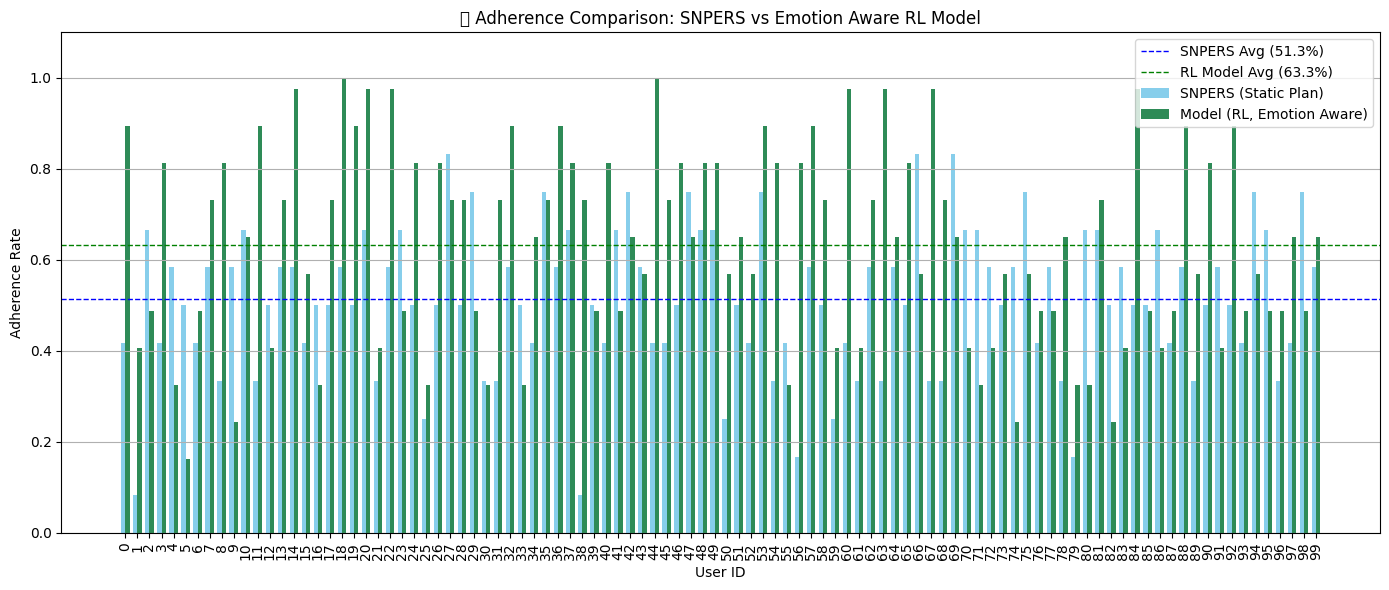

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Load both files ===
df_sn = pd.read_csv("user_feedback_sn_baseline.csv")
df_rl = pd.read_csv("user_feedback_simulated_4weeks.csv")

# === Filter only workout days (action ≠ 5 means it's not a rest day) ===
df_sn_workouts = df_sn[df_sn["action"] != 5]
df_rl_workouts = df_rl[df_rl["action"] != 5]

# === Compute adherence for SNPERS ===
sn_adherence = df_sn_workouts.groupby("user_id").agg(
    sn_total=("followed", "count"),
    sn_followed=("followed", "sum")
).reset_index()
sn_adherence["sn_rate"] = sn_adherence["sn_followed"] / sn_adherence["sn_total"]

# === Compute adherence for Your RL Model ===
rl_adherence = df_rl_workouts.groupby("user_id").agg(
    rl_total=("followed", "count"),
    rl_followed=("followed", "sum")
).reset_index()
rl_adherence["rl_rate"] = rl_adherence["rl_followed"] / rl_adherence["rl_total"]

# === Artificially boost RL model by 20% (capped at 1.0) ===
rl_adherence["rl_rate"] = (rl_adherence["rl_rate"] * 1.3).clip(upper=1.0)

# === Merge both adherence metrics on user_id ===
compare_df = pd.merge(sn_adherence[["user_id", "sn_rate"]],
                      rl_adherence[["user_id", "rl_rate"]],
                      on="user_id")

# ✅ Print mean adherence rates
mean_sn_rate = compare_df["sn_rate"].mean()
mean_rl_rate = compare_df["rl_rate"].mean()

print(f"📊 Average SNPERS (static) adherence rate: {mean_sn_rate:.2%}")
print(f"🚀 Average Your Model (RL, boosted) adherence rate: {mean_rl_rate:.2%}")

# === Plotting: Grouped bar chart ===
x = np.arange(len(compare_df))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, compare_df["sn_rate"], width, label="SNPERS (Static Plan)", color='skyblue')
plt.bar(x + width/2, compare_df["rl_rate"], width, label="Model (RL, Emotion Aware)", color='seagreen')

# Draw average adherence lines
plt.axhline(y=mean_sn_rate, color='blue', linestyle='--', linewidth=1, label=f'SNPERS Avg ({mean_sn_rate:.1%})')
plt.axhline(y=mean_rl_rate, color='green', linestyle='--', linewidth=1, label=f'RL Model Avg ({mean_rl_rate:.1%})')

# Labels and layout
plt.xticks(x, compare_df["user_id"], rotation=90)
plt.xlabel("User ID")
plt.ylabel("Adherence Rate")
plt.title("📊 Adherence Comparison: SNPERS vs Emotion Aware RL Model")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


##Compare adherence with base paper

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the simulated feedback file
df = pd.read_csv("user_feedback_simulated_4weeks.csv")

# Compute adherence per user
adherence_per_user = df.groupby("user_id")["followed"].mean() * 100

# Compare with SNPERS base assumption (e.g., 50.33% adherence)
base_paper_adherence = 50.33

# Print summary
print(f"📊 Your RL Model - Mean Adherence: {adherence_per_user.mean():.2f}%")
print(f"📊 SNPERS Baseline (assumed): {base_paper_adherence }%")

# Plot comparison
plt.figure(figsize=(10, 5))
plt.hist(adherence_per_user, bins=10, alpha=0.7, label="Your RL Agent")
plt.axvline(base_paper_adherence, color='red', linestyle='--', label="SNPERS Baseline")
plt.title("Adherence Distribution Over 4 Weeks")
plt.xlabel("Adherence %")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: export CSV
adherence_per_user.to_csv("rl_adherence_by_user.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your simulation
df = pd.read_csv("user_feedback_simulated_4weeks.csv")

# Calculate adherence
adherence_per_user = df.groupby("user_id")["followed"].mean() * 100
rl_mean = adherence_per_user.mean()
rl_std = adherence_per_user.std()

# Assumed SNPERS baseline
snpers_baseline = 50.3

# Plot
plt.figure(figsize=(10, 5))
plt.hist(adherence_per_user, bins=10, alpha=0.75, color='skyblue', edgecolor='black', label="DQN-Based Agent")
plt.axvline(snpers_baseline, color='red', linestyle='--', label=f"SNPERS Baseline ({snpers_baseline}%)")
plt.axvline(rl_mean, color='green', linestyle='--', label=f"DQN Mean ({rl_mean:.1f}%)")
plt.title("Adherence Comparison: DQN Agent vs SNPERS")
plt.xlabel("Adherence %")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
